In [1]:
import os, sys
sys.path.append(os.path.dirname(os.getcwd()) + '/source')

from experiment import solve_value_function, solve_alternative_ME
from simulation import simulation
from utilities import find_nearest_value
from numba import njit
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

In [2]:
ξ_w=1000.
# ξ_p=1./20
ξ_p=1./40
ξ_a=1./10000

damage_setting={'γ_2p': np.array([0, .0197*2, .3853*2]),
                'πd_o': np.array([1./3, 1./3, 1./3])}

# Solve for value function, baseline case
model_i_baseline, model_baseline = solve_value_function(1000., 1000., 1000., damage_setting)
# Sovle for value function, distorted case
model_i, model = solve_value_function(ξ_w, ξ_p, ξ_a, damage_setting)

# Compute ME for all cases
# Case 1: baseline
ME_total, ME_baseline = solve_alternative_ME(ξ_w, ξ_p, ξ_a,
                                             baseline_w=True, baseline_p=True, baseline_a=True,
                                             damage_setting=damage_setting)
# Case 2: minimize one of them
_, ME_min_w = solve_alternative_ME(ξ_w, ξ_p, ξ_a,
                                   baseline_w=False, baseline_p=True, baseline_a=True,
                                   damage_setting=damage_setting)
_, ME_min_p = solve_alternative_ME(ξ_w, ξ_p, ξ_a,
                                   baseline_w=True, baseline_p=False, baseline_a=True,
                                   damage_setting=damage_setting)
_, ME_min_a = solve_alternative_ME(ξ_w, ξ_p, ξ_a,
                                   baseline_w=True, baseline_p=True, baseline_a=False,
                                   damage_setting=damage_setting)

n_damage = len(damage_setting['πd_o'])
y_bar = model['y_grid'][-1]
y_grid_short = model['y_grid']
y_grid_long = model_i[0]['y_grid']

# Simulation
et, yt, ht, gt = simulation(model['y_grid'], model['e_tilde'], model['h'], model['g'],
                            θ=np.mean(model['θ']), y_start=np.mean(model['θ'])*290, T=100)
et_baseline, yt_baseline, _, _ \
               = simulation(model_baseline['y_grid'], model_baseline['e_tilde'],
                            model_baseline['h'], model_baseline['g'],
                            θ=np.mean(model['θ']), y_start=np.mean(model['θ'])*290, T=100)
yt_i = []
ht_i = []
for i in range(n_damage):
    _, y_temp, h_temp, _ = simulation(y_grid_long, model_i[i]['e_tilde'], model_i[i]['h'],
                               np.zeros_like(model_i[0]['e_tilde']).reshape(1, -1), θ=np.mean(model['θ']),
                               y_start=np.mean(model['θ'])*290, T=100)
    yt_i.append(y_temp)
    ht_i.append(h_temp)

Converged. Total iteration 5000: LHS Error: 6.396962327209765e-07; RHS Error 8.118508176509004e-07
Converged. Total iteration 2053: LHS Error: 9.964938936513068e-09; RHS Error 5.335233997220664e-06
Converged. Total iteration 2303: LHS Error: 9.988186416842737e-09; RHS Error 2.2741373048084995e-05
Converged. Total iteration 454: LHS Error: 9.614820786763012e-09; RHS Error 7.012756556147733e-06
Converged. Total iteration 5000: LHS Error: 1.972186705334611e-07; RHS Error 1.192363775056205e-06
Converged. Total iteration 2069: LHS Error: 9.985529410283522e-09; RHS Error 5.226509846720554e-06
Converged. Total iteration 2309: LHS Error: 9.978766590812427e-09; RHS Error 2.2286559435820134e-05
Converged. Total iteration 649: LHS Error: 9.956376272046707e-09; RHS Error 1.1266575812426586e-05
Converged. Total iteration 5000: LHS Error: 1.972186705334611e-07; RHS Error 1.192363775056205e-06
Converged. Total iteration 2069: LHS Error: 9.985529410283522e-09; RHS Error 5.226509846720554e-06
Converged

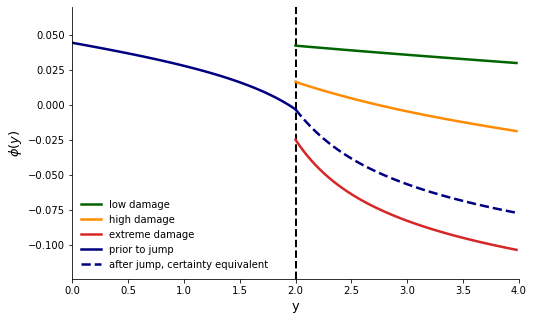

In [3]:
# 1. Plot value function
temp = np.array([res['v0'] for res in model_i])
certainty_equivalent = -ξ_p*np.log(np.average(np.exp(-1./ξ_p*temp), axis=0, weights=damage_setting['πd_o']))

plt.figure(figsize=(8, 5))
plt.plot(y_grid_long[y_grid_long>=y_bar], model_i[0]['v0'][y_grid_long>=y_bar],
         color='darkgreen', linewidth=2.5, label='low damage')
plt.plot(y_grid_long[y_grid_long>=y_bar], model_i[1]['v0'][y_grid_long>=y_bar],
         color='darkorange', linewidth=2.5, label='high damage')
if n_damage == 3:
    plt.plot(y_grid_long[y_grid_long>=y_bar], model_i[2]['v0'][y_grid_long>=y_bar],
             color='tab:red', linewidth=2.5, label='extreme damage')
plt.plot(y_grid_short, model['v0'], color='navy', linewidth=2.5, label='prior to jump')
plt.plot(y_grid_long[y_grid_long>=y_bar], certainty_equivalent[y_grid_long>=y_bar],
         color='navy', linewidth=2.5, linestyle='dashed', label='after jump, certainty equivalent')
y_min = np.min(model_i[2]['v0'])*1.2
y_max = np.max(model_i[0]['v0'])*1.2
plt.vlines(2., ymin=y_min, ymax=y_max, color='black', linestyle='dashed', linewidth=2.)
plt.xlim(0, 4.)
plt.ylim(y_min, y_max)
plt.legend(frameon=False)
plt.xlabel('y', fontsize=13)
plt.ylabel(r'$\phi(y)$', fontsize=13)
plt.savefig('../plots/standardized/value.pdf')

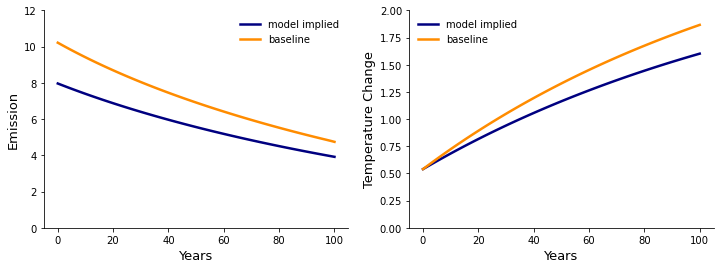

In [4]:
# 2. Plot emission and temperature change
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
ax1.plot(et, color='navy', label='model implied', linewidth=2.5)
ax1.plot(et_baseline, color='darkorange', label=r'baseline', linewidth=2.5)
ax1.set_xlabel('Years', fontsize=13)
ax1.set_ylabel('Emission', fontsize=13)
ax1.legend(frameon=False)
ax1.set_ylim(0., int(np.max(et_baseline)*1.2))

ax2.plot(yt, color='navy', label='model implied', linewidth=2.5)
ax2.plot(yt_baseline, color='darkorange', label='baseline', linewidth=2.5)
ax2.set_xlabel('Years', fontsize=13)
ax2.set_ylabel('Temperature Change', fontsize=13)
ax2.legend(frameon=False)
ax2.set_ylim(0., int(np.max(yt_baseline)*1.2))

fig.savefig('../plots/standardized/emission_temperature.pdf')

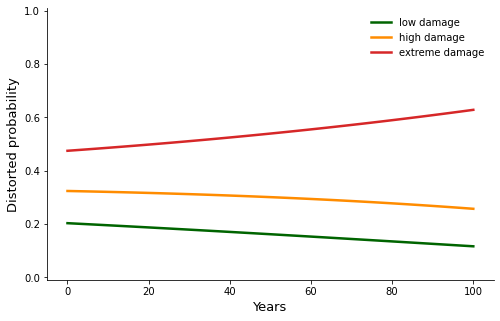

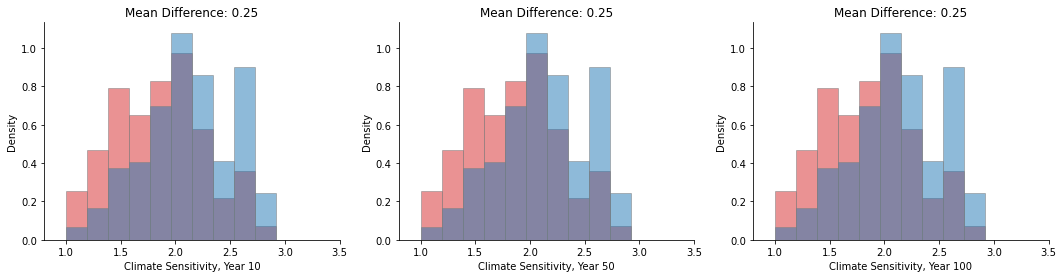

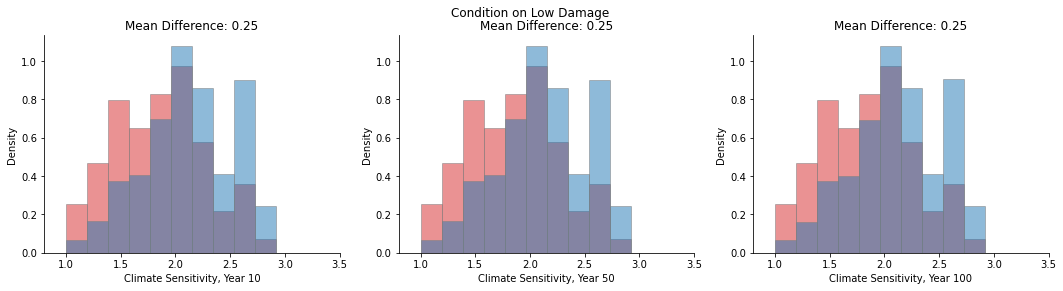

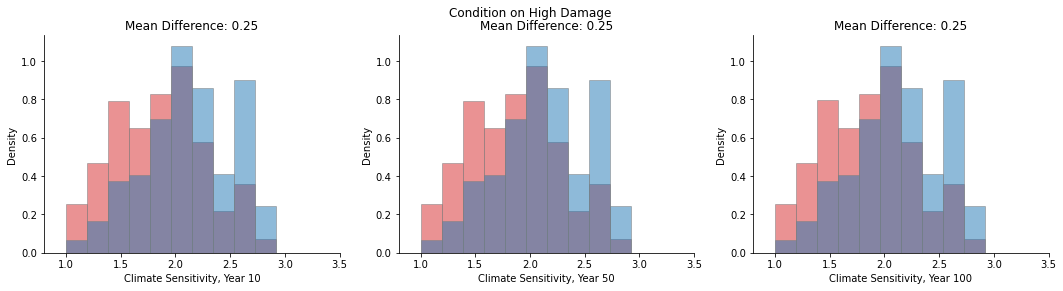

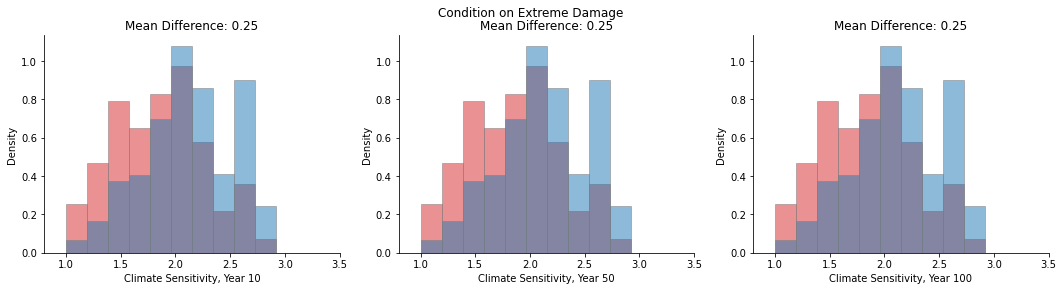

In [5]:
# 3.1 Plot distorted probabilities for damage function
plt.figure(figsize=(8, 5))
plt.plot(gt[0]*damage_setting['πd_o'][0]/np.mean(gt, axis=0), color='darkgreen', label='low damage', linewidth=2.5)
plt.plot(gt[1]*damage_setting['πd_o'][1]/np.mean(gt, axis=0), color='darkorange', label='high damage', linewidth=2.5)
if n_damage == 3:
    plt.plot(gt[2]*damage_setting['πd_o'][2]/np.mean(gt, axis=0), color='tab:red', label='extreme damage', linewidth=2.5)
plt.xlabel('Years', fontsize=13)
plt.ylabel('Distorted probability', fontsize=13)
plt.ylim(-.01, 1.01)
plt.legend(frameon=False)
plt.savefig('../plots/standardized/damage_probability.pdf')

# 3.2 Plot distorted probabilities for climate sensitivity
T_low = 10
T_mid = 50
T_high = 100
loc_low = find_nearest_value(y_grid_short, yt[T_low])
loc_mid = find_nearest_value(y_grid_short, yt[T_mid])
loc_high = find_nearest_value(y_grid_short, yt[T_high])

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,4))

bins = np.linspace(1, 3.5, 14)

ax1.hist(model['θ']*1000, bins=bins, color='tab:red', histtype='bar', ec='gray', alpha=.5, density=True)
ax1.hist((model['θ']+model['σ_y']*ht[T_low])*1000, weights=model['πc'][:, loc_low], bins=bins, color='tab:blue', histtype='bar', ec='gray', alpha=.5, density=True)
ax1.set_xlabel('Climate Sensitivity, Year '+str(T_low))
ax1.set_ylabel('Density')
ax1.set_title('Mean Difference: ' + str(((model['θ']@(model['πc'][:, loc_low])-np.mean(model['θ']))+model['σ_y']*ht[T_low])*1000)[:4])
ax1.set_xlim(.8, 3.5)

ax2.hist(model['θ']*1000, bins=bins, color='tab:red', histtype='bar', ec='gray', alpha=.5, density=True)
ax2.hist((model['θ']+model['σ_y']*ht[T_mid])*1000, weights=model['πc'][:, loc_mid], bins=bins, color='tab:blue', histtype='bar', ec='gray', alpha=.5, density=True)
ax2.set_xlabel('Climate Sensitivity, Year '+str(T_mid))
ax2.set_ylabel('Density')
ax2.set_title('Mean Difference: ' + str(((model['θ']@(model['πc'][:, loc_mid])-np.mean(model['θ']))+model['σ_y']*ht[T_mid])*1000)[:4])
ax2.set_xlim(.8, 3.5)

ax3.hist(model['θ']*1000, bins=bins, color='tab:red', histtype='bar', ec='gray', alpha=.5, density=True)
ax3.hist((model['θ']+model['σ_y']*ht[T_high])*1000, weights=model['πc'][:, loc_high], bins=bins, color='tab:blue', histtype='bar', ec='gray', alpha=.5, density=True)
ax3.set_xlabel('Climate Sensitivity, Year '+str(T_high))
ax3.set_ylabel('Density')
ax3.set_title('Mean Difference: ' + str(((model['θ']@(model['πc'][:, loc_high])-np.mean(model['θ']))+model['σ_y']*ht[T_high])*1000)[:4])
ax3.set_xlim(.8, 3.5)

fig.savefig('../plots/standardized/climate_histogram.pdf')

# 3.3.1 Plot distorted probabilities for climate sensitivity conditional on low damage
fig_names = ['_low_damage.pdf', '_high_damage.pdf', '_extreme_damage.pdf']
sup_titles = ['Condition on Low Damage', 'Condition on High Damage', 'Condition on Extreme Damage']
for i in range(n_damage):
    loc_low = find_nearest_value(y_grid_long, yt_i[i][T_low])
    loc_mid = find_nearest_value(y_grid_long, yt_i[i][T_mid])
    loc_high = find_nearest_value(y_grid_long, yt_i[i][T_high])

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,4))

    bins = np.linspace(1, 3.5, 14)
    
    θ = model['θ']
    σ_y = model['σ_y']
    fig.suptitle(sup_titles[i])
    ax1.hist(θ*1000, bins=bins, color='tab:red', histtype='bar', ec='gray', alpha=.5, density=True)
    ax1.hist((θ+σ_y*ht_i[i][T_low])*1000, weights=model_i[i]['πc'][:, loc_low], bins=bins, color='tab:blue', histtype='bar', ec='gray', alpha=.5, density=True)
    ax1.set_xlabel('Climate Sensitivity, Year '+str(T_low))
    ax1.set_ylabel('Density')
    ax1.set_title('Mean Difference: ' + str(((θ@(model_i[i]['πc'][:, loc_low])-np.mean(θ))+σ_y*ht_i[i][T_low])*1000)[:4])
    ax1.set_xlim(.8, 3.5)

    ax2.hist(θ*1000, bins=bins, color='tab:red', histtype='bar', ec='gray', alpha=.5, density=True)
    ax2.hist((θ+σ_y*ht_i[i][T_mid])*1000, weights=model_i[i]['πc'][:, loc_mid], bins=bins, color='tab:blue', histtype='bar', ec='gray', alpha=.5, density=True)
    ax2.set_xlabel('Climate Sensitivity, Year '+str(T_mid))
    ax2.set_ylabel('Density')
    ax2.set_title('Mean Difference: ' + str(((θ@(model_i[i]['πc'][:, loc_mid])-np.mean(θ))+σ_y*ht_i[i][T_mid])*1000)[:4])
    ax2.set_xlim(.8, 3.5)

    ax3.hist(θ*1000, bins=bins, color='tab:red', histtype='bar', ec='gray', alpha=.5, density=True)
    ax3.hist((θ+σ_y*ht_i[i][T_high])*1000, weights=model_i[i]['πc'][:, loc_high], bins=bins, color='tab:blue', histtype='bar', ec='gray', alpha=.5, density=True)
    ax3.set_xlabel('Climate Sensitivity, Year '+str(T_high))
    ax3.set_ylabel('Density')
    ax3.set_title('Mean Difference: ' + str(((θ@(model_i[i]['πc'][:, loc_high])-np.mean(θ))+σ_y*ht_i[i][T_high])*1000)[:4])
    ax3.set_xlim(.8, 3.5)

    fig.savefig('../plots/standardized/climate_histogram'+fig_names[i])

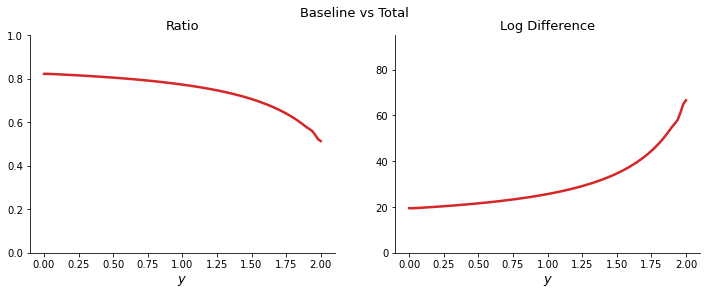

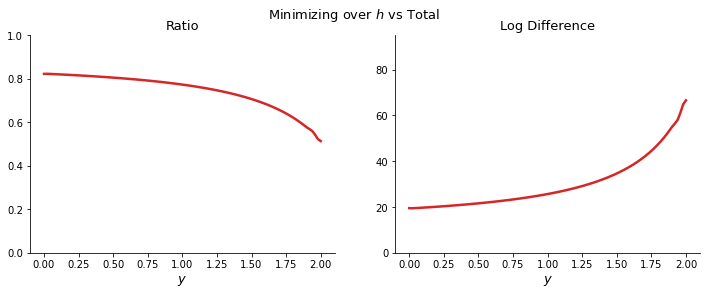

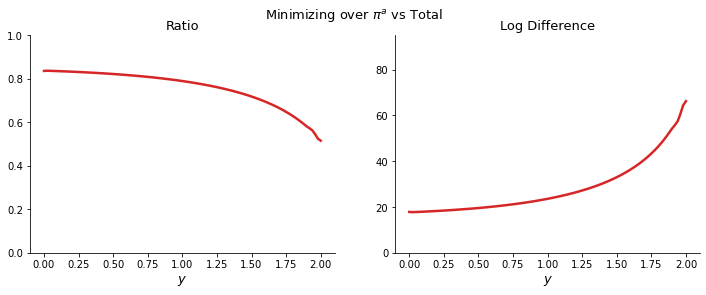

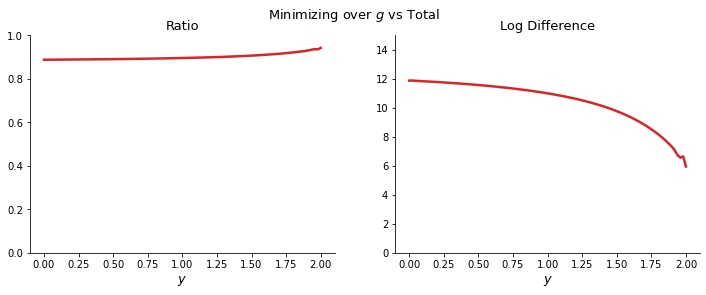

In [6]:
# 4. Plot ME ratio, log difference for different cases
# Case 1.
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(12,4))
fig.suptitle('Baseline vs Total', fontsize=13)
ratio = ME_baseline/ME_total
ax1.plot(y_grid_short, ratio, color='tab:red', linewidth=2.5)
ax1.set_xlabel('$y$', fontsize=13)
ax1.set_title('Ratio', fontsize=13)
ax1.set_ylim(0, 1)

log_diff = -np.log(ME_baseline/ME_total)*100
ax2.plot(y_grid_short, log_diff, color='tab:red', linewidth=2.5)
ax2.set_xlabel(r'$y$', fontsize=13)
ax2.set_ylim(0, int(np.max(log_diff)*1.5/5)*5)
ax2.set_title('Log Difference', fontsize=13)

fig.savefig('../plots/standardized/me_baseline.pdf')

# Case 2.
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(12,4))
fig.suptitle(r'Minimizing over $h$ vs Total', fontsize=13)
ratio = ME_min_w/ME_total
ax1.plot(y_grid_short, ratio, color='tab:red', linewidth=2.5)
ax1.set_xlabel('$y$', fontsize=13)
ax1.set_title('Ratio', fontsize=13)
ax1.set_ylim(0, 1)

log_diff = -np.log(ME_min_w/ME_total)*100
ax2.plot(y_grid_short, log_diff, color='tab:red', linewidth=2.5)
ax2.set_xlabel(r'$y$', fontsize=13)
ax2.set_ylim(0, int(np.max(log_diff)*1.5/5)*5)
ax2.set_title('Log Difference', fontsize=13)

fig.savefig('../plots/standardized/me_min_w.pdf')

# Case 3.
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(12,4))
fig.suptitle(r'Minimizing over $\pi^a$ vs Total', fontsize=13)
ratio = ME_min_a/ME_total
ax1.plot(y_grid_short, ratio, color='tab:red', linewidth=2.5)
ax1.set_xlabel('$y$', fontsize=13)
ax1.set_title('Ratio', fontsize=13)
ax1.set_ylim(0, 1)

log_diff = -np.log(ME_min_a/ME_total)*100
ax2.plot(y_grid_short, log_diff, color='tab:red', linewidth=2.5)
ax2.set_xlabel(r'$y$', fontsize=13)
ax2.set_ylim(0, int(np.max(log_diff)*1.5/5)*5)
ax2.set_title('Log Difference', fontsize=13)

fig.savefig('../plots/standardized/me_min_a.pdf')

# Case 4.
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(12,4))
fig.suptitle(r'Minimizing over $g$ vs Total', fontsize=13)
ratio = ME_min_p/ME_total
ax1.plot(y_grid_short, ratio, color='tab:red', linewidth=2.5)
ax1.set_xlabel('$y$', fontsize=13)
ax1.set_title('Ratio', fontsize=13)
ax1.set_ylim(0, 1)

log_diff = -np.log(ME_min_p/ME_total)*100
ax2.plot(y_grid_short, log_diff, color='tab:red', linewidth=2.5)
ax2.set_xlabel(r'$y$', fontsize=13)
ax2.set_ylim(0, int(np.max(log_diff)*1.5/5)*5)
ax2.set_title('Log Difference', fontsize=13)
fig.savefig('fig_ambiguity_damage_averse.pdf')

fig.savefig('../plots/standardized/me_min_p.pdf')


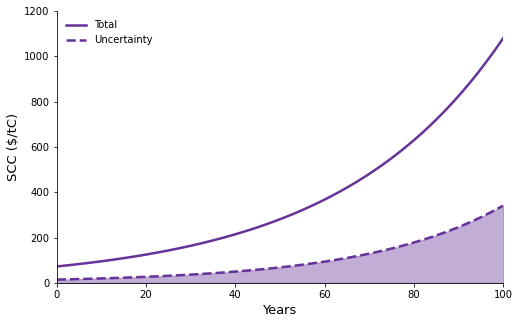

In [7]:
# 5. Plot SCC
def simulation_me(y_grid, e_grid, ratio_grid, θ=1.86/1000., y_start=.5394, T=50):
    Et = np.zeros(T+1)
    yt = np.zeros(T+1)
    ratio_t = np.zeros(T+1)
    for i in range(T+1):
        Et[i] = np.interp(y_start, y_grid, e_grid)
        ratio_t[i] = np.interp(y_start, y_grid, ratio_grid)
        yt[i] = y_start
        y_start = y_start + Et[i]*θ
    return Et, yt, ratio_t

et_tilde, yt, ratio_t = simulation_me(y_grid_short, model['e_tilde'], 
                                      ME_baseline/ME_total, θ=np.mean(θ), y_start=np.mean(θ)*290, T=100)

# Capital and z parameters
α_k = -0.043
β_k = 0.04
σ_k = np.array([0.477*2, 0])/100.
β_z = 0.014*4
σ_z = np.array([0.011*2, 0.025*2])
α = 0.115
ioverk = 0.09
κ = 6.667


@njit(parallel=True)
def simulate_capital(α_k, β_k, σ_k, β_z, σ_z, ioverk, κ, Ws, k_start, N=100_000, T=100, dt=1.):
    var_z = dt*σ_z@σ_z/(1-(1-β_z*dt)**2)
    std_z = np.sqrt(var_z)

    time_periods = int(T/dt)
    z_path = np.zeros((N, time_periods+1))
    k_path = np.zeros((N, time_periods+1))
    for i in range(N):
        z0 = np.random.normal(0.,std_z)
        k0 = k_start
        z_path[i, 0] = z0
        k_path[i, 0] = k0
        for j in range(1, time_periods+1):
            k1 = k0 + (α_k + β_k*z0 + ioverk - κ/2.*ioverk**2 - σ_k@σ_k/2.)*dt + σ_k@Ws[i, j]*np.sqrt(dt)
            z1 = (1.-β_z*dt)*z0 + σ_z@Ws[i, j]*np.sqrt(dt)
            k_path[i, j] = k1
            z_path[i, j] = z1
            k0 = k1
            z0 = z1
    return k_path

T = 100
N = 1_000_000
dt = 1.
k_start = np.log(80/α)
η = .032
Ws = np.random.multivariate_normal(np.zeros(2), np.eye(2), (N, int(T/dt)))
logk_path = simulate_capital(α_k, β_k, σ_k, β_z, σ_z, ioverk, κ, Ws, k_start, N=N, T=T, dt=dt)
Kt = np.percentile(np.exp(logk_path), 50, axis=0)

SCCt_all = η*(0.025)*Kt/((1.-η)*et_tilde) * 1000
SCCt_baseline = SCCt_all * ratio_t
SCCt_uncertainty = SCCt_all - SCCt_baseline

plt.figure(figsize=(8, 5))
plt.plot(SCCt_all, color='rebeccapurple', label='Total', linewidth=2.5)
plt.plot(SCCt_uncertainty, color='rebeccapurple', label='Uncertainty', linestyle='dashed', linewidth=2.5)
plt.fill_between(np.arange(0, 101, 1), np.zeros_like(SCCt_uncertainty), 
                 SCCt_uncertainty, color='rebeccapurple', alpha=.4)
plt.ylim(0, 1200)
plt.xlim(0, 100)
plt.xlabel('Years', fontsize=13)
plt.ylabel('SCC ($/tC)', fontsize=13)
plt.legend(frameon=False)
plt.savefig('../plots/standardized/scc.pdf')